To-do:

    Only generate for 4 classes in 4 class case
    Remove outliers
    Speed improvements
    Different colors for resampled data

In [1]:
import pandas as pd
import numpy as np
import string, math, collections, typing, warnings
import imblearn, matplotlib
from matplotlib import pyplot as plt
from sklearn import decomposition, manifold

In [2]:
#Configurations
warnings.filterwarnings('ignore')

In [3]:
#Global variables
methods = {'SMOTETomek': imblearn.combine.SMOTETomek, 
           'RandomOver': imblearn.over_sampling.RandomOverSampler,
           'ADASYN': imblearn.over_sampling.ADASYN,
           'RandomUnder': imblearn.under_sampling.RandomUnderSampler,
           'none': None,}
INPUT_NAME = 'text'
OUTPUT_NAMES = ['Binary', '4-type', '5-type']
THRESHOLD_PCT = 0.5 #minimum percent of text that must be taken up by a particular word
PCA_DIMS = 50 #dimensions to reduce to with PCA before applying t-SNE
TSNE_DIMS = 2
TSNE_PERPLEXITY = 40
TSNE_ITER = 300 #number of iterations for t-SNE

In [4]:
#Word representations
def bow(text: str, wordlist: list[str]) -> list[int]:
    '''Represent text with bag of words.'''
    return [int(word in text) for word in wordlist]

def freq(text: str, wordlist: list[str]) -> list[float]:
    '''Represent text with frequencies.'''
    text = text.split()
    counter = collections.Counter(text)
    length = len(text)
    return [value_or_zero(word, counter)/length for word in wordlist]

def tfidf(text: str, word_dict: dict[str, float]) -> list[float]:
    '''Represent text with TF-IDF'''
    text = text.split()
    counter = collections.Counter(text)
    length = len(text)
    frequencies = [value_or_zero(word, counter)/length for word in word_dict]
    return [word_dict[word] * frequencies[i] for (i, word) in enumerate(word_dict)]

In [5]:
#Data formatting and wrangling functions
def get_all_text(df: pd.DataFrame, output_index: int) -> str:
    '''Get a string with all text from a pandas DataFrame.'''
    return ' '.join(list(df[INPUT_NAME]))

def combine_answers(df: pd.DataFrame, names: list[str]) -> pd.DataFrame:
    '''Combine the answers to get the 5-type class'''
    df = df.fillna(0)
    columns = list(df.columns.values)
    data_type, classification = columns.index(names[0]), columns.index(names[1])
    df[OUTPUT_NAMES[2]] = df.apply(lambda x: x[data_type] + x[classification], axis=1)
    return df

def remove_uncommon_words(wordlist: list[str], text_counter: dict[str, int]) -> list[str]:
    '''Remove words that are uncommon, below a certain threshold.'''
    return [word for word in wordlist if text_counter[word]*100/len(wordlist) >= THRESHOLD_PCT]

def get_wordlist(df: pd.DataFrame, output_index: str) -> tuple[list[str], dict[str, int]]:
    '''Get the wordlist for a dataframe.'''
    all_text_split = get_all_text(df, output_index).split()
    all_text_counter = collections.Counter(all_text_split)
    return remove_uncommon_words(list(set(all_text_split)), all_text_counter), all_text_counter

def get_worddict(df: pd.DataFrame, output_index: str, frequency_counter: dict[str, int], 
                 wordlist: list[str]) -> dict[str, float]:
    '''Get the word dict for a dataframe, for the TF-IDF encoding.'''
    all_text_split = get_all_text(df, output_index).split()
    all_text_counter = collections.Counter(all_text_split)
    word_dict = dict()
    for word in wordlist:
        value = math.log(len(wordlist)/all_text_counter[word])
        word_dict[word] = value
    return word_dict

def resample(inputs: np.ndarray, outputs: np.ndarray, resampling_method: str) -> tuple[np.ndarray, np.ndarray]:
    '''Resample a dataset with a resampling method.'''
    try:
        if resampling_method == 'aug':
            pass
        elif resampling_method == 'ADASYN':
            inputs, outputs = methods[resampling_method](sampling_strategy='minority').fit_resample(inputs, outputs)
        elif resampling_method != 'none':
            inputs, outputs = methods[resampling_method]().fit_resample(inputs, outputs)
    except ValueError: #sometimes it doesn't generate any new samples, which gives value error. In that case, return original.
        pass
    return inputs, outputs

def pca_reduce(array: np.ndarray) -> np.ndarray:
    '''Reduce the dimensions to a smaller number using PCA.'''
    dims = min(PCA_DIMS, array.shape[0], array.shape[1])
    pca = decomposition.PCA(n_components=dims)
    return np.array(pca.fit_transform(array))

def tsne_reduce(array: np.ndarray) -> np.ndarray:
    '''Reduce to two-dimensional data using PCA and t-SNE.'''
    array = pca_reduce(array) #get reasonable number of dimensions to then use t-SNE on.
    tsne = manifold.TSNE(n_components=TSNE_DIMS, perplexity=TSNE_PERPLEXITY, n_iter=TSNE_ITER)
    return np.array(tsne.fit_transform(array))

def value_or_zero(key: str, temp_dict: dict[str, int]) -> int:
    '''Return value in a dictionary or zero if key not in dictionary.'''
    return 0 if key not in temp_dict else temp_dict[key]

def delete_punctuation(input_string: str) -> str:
    '''Delete the punctuation from a string.'''
    return ''.join(char for char in input_string if char not in string.punctuation)

In [6]:
#Primary visualization functions
def visualize_rep_method(inputs: np.ndarray, outputs: np.ndarray, name: str, ax: matplotlib.axes.Axes) -> None:
    '''Visualize a particular representation and resampling method.'''
    inputs = tsne_reduce(inputs)
    range_ten = range(10)
    unique_items = [unique for unique in list(set(outputs)) if unique in range_ten] #get rid of nans
    for unique_output in unique_items:
        temp_inputs = np.array([item for (i, item) in enumerate(inputs) if outputs[i] == unique_output])
        ax.scatter(temp_inputs[:, 0], temp_inputs[:, 1], label=unique_output, s=0.75)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.legend()

def visualize_method(df: pd.DataFrame, method: str, task: str, task_index: int) -> None:
    '''Visualize each representation using a resampling method.'''
    wordlist, frequency_counter = get_wordlist(df, task_index)
    word_dict = get_worddict(df, task_index, frequency_counter, wordlist)
    rep_methods = [{'name': 'bow', 'function': bow, 'wordlist': wordlist}, #methods for representing text
                   {'name': 'freq', 'function': freq, 'wordlist': wordlist},
                   {'name': 'tfidf', 'function': tfidf, 'wordlist': word_dict},]
    
    fig, axs = plt.subplots(len(rep_methods))
    for (i, rep_method) in enumerate(rep_methods):
        rep_name, rep_func, rep_list = rep_method['name'], rep_method['function'], rep_method['wordlist']
        inputs = df[INPUT_NAME].apply(lambda x: rep_func(x, rep_list)).to_numpy()
        inputs = np.array([np.array(x) for x in inputs]) #it doesn't do this automatically for some reason
        outputs = df[task].to_numpy()
        outputs = np.array([np.array(x) for x in outputs])
        inputs, outputs = resample(inputs, outputs, method)
        visualize_rep_method(inputs, outputs, rep_name, axs[i])
    plt.show()

In [7]:
def generate(filename: str, input_name: str, output_names: list[str], task: str, task_index: int, augmented: bool = False) -> None:
    '''Generate all visualizations for a datafile and task given their names.'''
    df = pd.read_csv(filename)
    #ensure i/o columns all have the same names
    df[INPUT_NAME] = df[input_name].astype(str)
    df = combine_answers(df, output_names)
    for (i, incorrect_output_name) in enumerate(output_names):
        df[OUTPUT_NAMES[i]] = df[incorrect_output_name]
        df[OUTPUT_NAMES[i]]
    
    if augmented:
        visualize_method(df, 'aug', task, i)
    else:
        for method in methods:
            print(f'RESAMPLING METHOD: {method}')
            visualize_method(df, method, task, i)

def file_generate(filename: str, names: list[str], augmented: bool = False) -> None:
    '''Generate all visualizations for a file.'''
    for (i, task) in enumerate(OUTPUT_NAMES):
        print(f'TASK: {task}')
        generate(filename, INPUT_NAME, names, task, i, augmented)

TASK: Binary
RESAMPLING METHOD: SMOTETomek


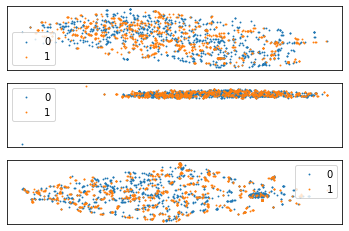

RESAMPLING METHOD: RandomOver


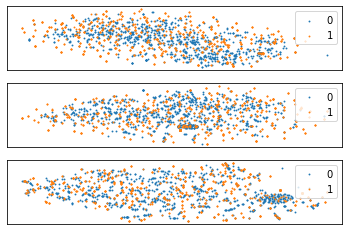

RESAMPLING METHOD: ADASYN


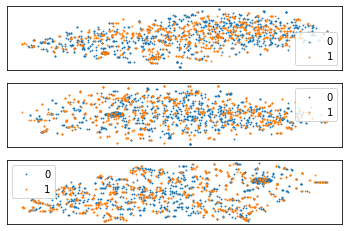

RESAMPLING METHOD: RandomUnder


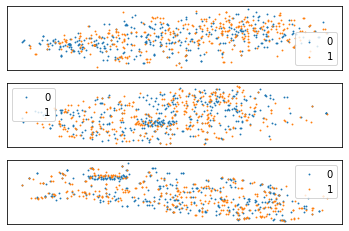

RESAMPLING METHOD: none


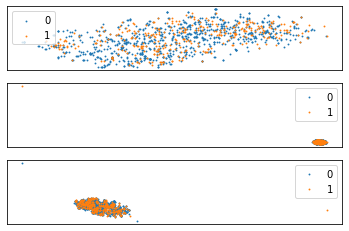

TASK: 4-type
RESAMPLING METHOD: SMOTETomek


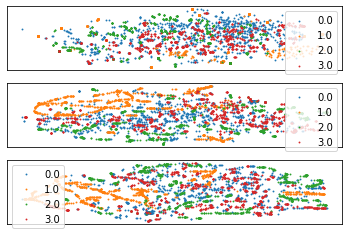

RESAMPLING METHOD: RandomOver


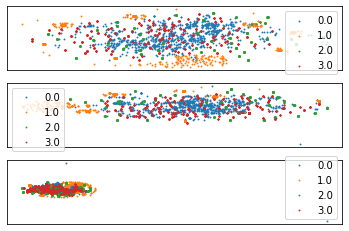

RESAMPLING METHOD: ADASYN


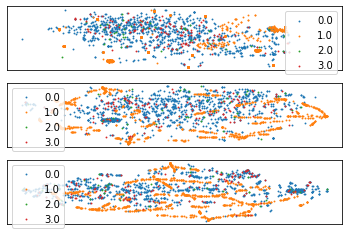

RESAMPLING METHOD: RandomUnder


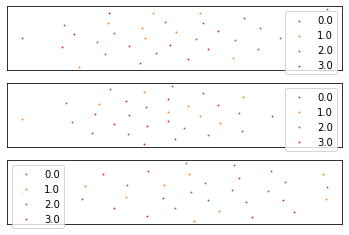

RESAMPLING METHOD: none


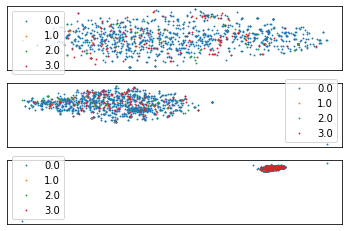

TASK: 5-type
RESAMPLING METHOD: SMOTETomek


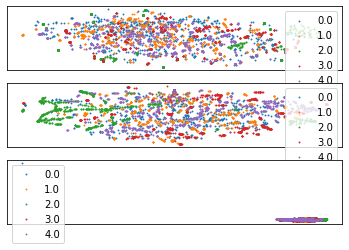

RESAMPLING METHOD: RandomOver


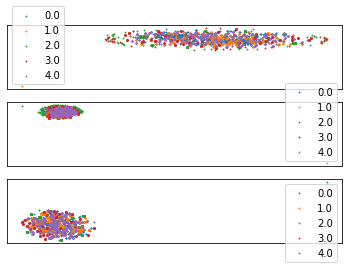

RESAMPLING METHOD: ADASYN


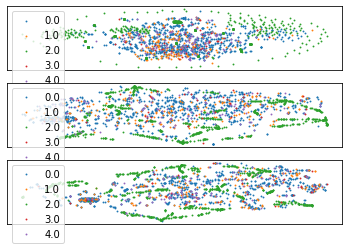

RESAMPLING METHOD: RandomUnder


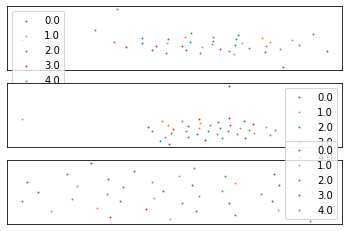

RESAMPLING METHOD: none


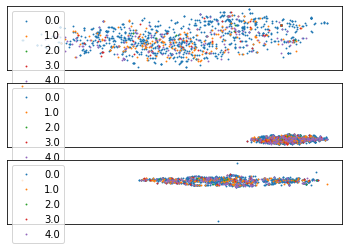

In [8]:
file_generate('../data/antisemitism_dataset.csv', ['classification', 'type_of_antisemitism'])

TASK: Binary


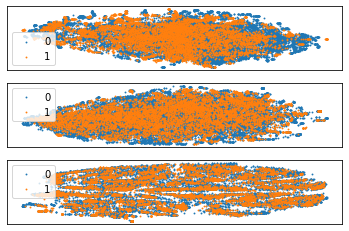

TASK: 4-type


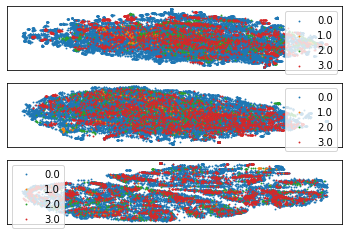

TASK: 5-type


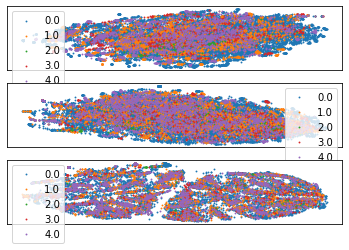

In [9]:
file_generate('../data/augmented_dataset.csv', ['classification', 'type'], augmented=True)